## CSE Computer Vision Assignment 3
**Name :** Arka Sarkar <br>
**Roll Number :** 2018222

In [1]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/CV_Assignment3

/gdrive/MyDrive/CV_Assignment3


**Checking for GPU device**

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [2]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


**Importing Dependencies**

In [3]:
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import pickle
import cv2
import csv
from keras.preprocessing import image
from keras.utils import layer_utils
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import random
from sklearn.metrics import jaccard_score

#### Original MNIST Dataset 
**MNIST** Handwritten Digit Classification Dataset <br>
It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9. The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively 

In [442]:
train_df = pd.read_csv("dataset/mnist_train.csv")
test_df = pd.read_csv("dataset/mnist_test.csv")

In [443]:
train_df

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [444]:
train = np.array(train_df)
test = np.array(test_df)

Y_train = np.zeros((train.shape[0], 10))
X_train = []
Y_test = np.zeros((test.shape[0], 10))
X_test = []

for i in range(train.shape[0]):
    X_train.append(train[i,1:])
    Y_train[i,train[i,0]] = 1
    
for i in range(test.shape[0]):
    X_test.append(test[i,1:])
    Y_test[i,test[i,0]] = 1

X_train = np.array(X_train)
X_test = np.array(X_test)
print("Testing X Shape : ", X_test.shape)
print("Training X Shape : ", X_train.shape)
print("Testing Y Shape : ",Y_test.shape)
print("Training Y Shape : ",Y_train.shape)

Testing X Shape :  (10000, 784)
Training X Shape :  (60000, 784)
Testing Y Shape :  (10000, 10)
Training Y Shape :  (60000, 10)


###### sample MNIST image

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


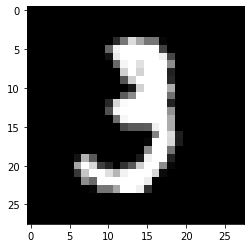

In [445]:
idx = 10
sample = X_train[idx].reshape((28,28))
print(Y_train[idx])
plt.imshow(sample, cmap = "gray")

**OTSU TTS thresholding** <br>
The formula for otsu tts thresholding is : <br>

$$threshold = min(\sum_{i=0}^{j}(\ x_i - \overline{x(:j)}\ )^2 + \sum_{i=j}^{n}(\ x_i - \overline{x(j:)}\ )^2 ), n = 255$$

In [446]:
def otsu_tts(img):
    img = img.reshape((28,28))
    min_cost = float('inf')
    threshold = 0

    for i in range(1,256):
        v0 = img[img < i]
        s0 = np.sum((v0 - np.mean(v0))**2)
        w0 = len(img[img < i])
        v1 = img[img >= i]
        s1 = np.sum((v1 - np.mean(v1))**2)
        w1 = len(img[img >= i])

        cost = s0 + s1
        if(cost < min_cost):
            min_cost = cost
            threshold = i

    return threshold

def select_foreground(img, s = 0):
    if(s == 0):
        m,n = img.shape
        
        m0 = int(0.15*m)
        n0 = int(0.15*n)
        c0 = 0
        c1 = 0
        for i in range(m//2 - m0, m//2 + m0):
            for j in range(n//2 - n0, n//2 + n0):
                if(img[i,j] == 0):
                    c0 = c0 + 1
                else:
                    c1 = c1 + 1
        if(c0 > c1):
            return 0
        else :
            return 1
    else : 
        
        m,n = img.shape
        
        m0 = 10
        n0 = 10
        c0 = 0
        c1 = 0
        for i in range(m):
            for j in range(n):
                if (i < m0): 
                    if(img[i,j] == 0):
                        c0 = c0 + 1
                    else:
                        c1 = c1 + 1
                    
                elif (i > m-m0): 
                    if(img[i,j] == 0):
                        c0 = c0 + 1
                    else:
                        c1 = c1 + 1
                elif (j < n0): 
                    if(img[i,j] == 0):
                        c0 = c0 + 1
                    else:
                        c1 = c1 + 1
                elif (j > n-n0): 
                    if(img[i,j] == 0):
                        c0 = c0 + 1
                    else:
                        c1 = c1 + 1
                
        if(c0 > c1):
            return 0
        else :
            return 1

## Question 1
Perform the following on MNIST dataset to build three new datasets: <br>

1. Obtain foreground segmentation masks for images in MNIST dataset using TSS-based threshold [Q1, Assignment 1]. In this way, you have rough groundtruth masks required to build a new foreground segmentation dataset. [1 Mark] <br>
Note: The pre-existing labels are of no use here. The goal of the dataset is just to extract
the foreground.  <br>
2. Obtain tight groundtruth circles around the foreground segmentation masks obtained in (a). In this way, you can build a new dataset of 10 classes for performing classification with circlization (circular localization). You can use existing libraries for generating the tight circles. [1 Mark] <br>
3. Randomly concatenate 4 images and their corresponding groundtruths obtained in (a),along with the pre-existing labels, in a 2x2 manner to develop new images and semantic segmentation groundtruths, respectively. In this way, you have a new dataset of 10 classes for performing semantic segmentation. [2 Marks]


### part (a)



In [ ]:
# run only once 
# making the training set 
fg_masks_train = []
for i in tqdm(range(len(X_train)), position = 0, desc = "Progress : "):
    thres = otsu_tts(X_train[i])
    img = X_train[i].reshape((28,28))
    mask = copy.deepcopy(img)
    mask[mask<thres] = 0 
    mask[mask > thres] = 1
    fg_masks_train.append(mask.flatten())

###### Saving the dataset in a .csv file.

In [ ]:
with open('dataset/Q1fg_mask_train.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerows(fg_masks_train)

In [ ]:
# run only once 
# making the testing set 

fg_masks_test = []
for i in tqdm(range(len(X_test)), position = 0, desc = "Progress : "):
    thres = otsu_tts(X_test[i])
    img = X_test[i].reshape((28,28))
    mask = copy.deepcopy(img)
    mask[mask<thres] = 0 
    mask[mask > thres] = 1
    fg_masks_test.append(mask.flatten())

###### Saving the dataset in a .csv file.

In [ ]:
with open('dataset/Q1fg_mask_test.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerows(fg_masks_test)

In [447]:
idx  = 10
sample_x = np.array(pd.read_csv('dataset/mnist_train.csv'))[idx,1:].reshape((28,28))
sample_y = np.array(pd.read_csv('dataset/Q1fg_mask_train.csv', header = None))[idx].reshape((28,28))


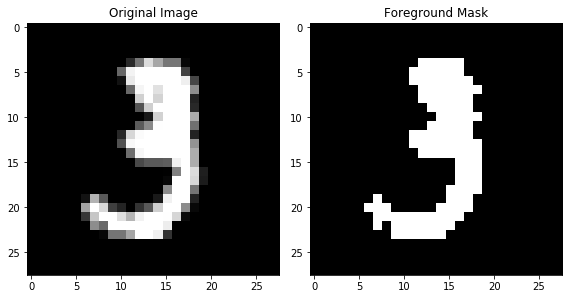

In [448]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(sample_x, cmap = 'gray')
plt.title("Original Image")
fig.add_subplot(rows, columns, 2)
plt.imshow(sample_y, cmap = 'gray')
plt.title("Foreground Mask")
fig.tight_layout() 
plt.show()


### part (b)



In [ ]:
X_train = pd.read_csv("dataset/Q1fg_mask_train.csv", header = None)
X_test = pd.read_csv("dataset/Q1fg_mask_test.csv", header= None)
y_label_train = np.array(pd.read_csv("dataset/mnist_train.csv"))[:,0]
y_label_test = np.array(pd.read_csv("dataset/mnist_test.csv"))[:,0]
X_train = np.array(X_train)
X_test = np.array(X_test)

###### Writing the MNIST images into disc

In [ ]:
#code for saving the original images
#run once
X_orig_train = np.array(pd.read_csv("dataset/mnist_train.csv"))[:,1:]

for i in tqdm(range(len(X_orig_train)), position = 0, desc = "Progress : "):
    img = X_orig_train[i].reshape((28,28))
    cv2.imwrite('dataset/mnist_images/train/' + str(i) + '.png', img )


Progress : 100%|██████████| 60000/60000 [08:52<00:00, 112.63it/s]


In [ ]:
#code for saving the original images
#run once
X_orig_test = np.array(pd.read_csv("dataset/mnist_test.csv"))[:,1:]
for i in tqdm(range(len(X_orig_test)), position = 0, desc = "Progress : "):
    img = X_orig_test[i].reshape((28,28))
    cv2.imwrite('dataset/mnist_images/test/' + str(i) + '.png', img )

Progress : 100%|██████████| 10000/10000 [01:29<00:00, 111.89it/s]


###### Writing the MNIST foreground images obtained in (a) into disc

In [ ]:
#code for saving the fg images
#run once


for i in tqdm(range(len(X_train)), position = 0, desc = "Progress : "):
    img = X_train[i].reshape((28,28))*255
    cv2.imwrite('dataset/mnist_images_fg/train/' + str(i) + '.png', img )


Progress : 100%|██████████| 60000/60000 [09:06<00:00, 109.83it/s]


In [ ]:
#code for saving the fg images
#run once
for i in tqdm(range(len(X_test)), position = 0, desc = "Progress : "):
    img = X_test[i].reshape((28,28))*255
    cv2.imwrite('dataset/mnist_images_fg/test/' + str(i) + '.png', img )

Progress : 100%|██████████| 10000/10000 [01:27<00:00, 114.41it/s]


### Center Radius Dataset
**Dataset columns : 'label','x','y', 'radius'** <br>
**Dataset Size :** (n_samples, 4)<br>
**'label'** : labels of the image ranging from 0 to 9. <br> 
**'x'** : normalsed x coordinate for the bounding circle. <br>
**'y'** : normalsed y coordinate for the bounding circle. <br>
**'radius'** : normalsed radius coordinate for the bounding circle. <br>    

In [ ]:
# making the center radius dataset 
center_radius_dataset_train = []

for i in tqdm(range(60000)):
    img = cv2.imread('dataset/mnist_images_fg/train/' + str(i) + '.png',cv2.IMREAD_GRAYSCALE)
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    (x,y), radius = cv2.minEnclosingCircle(cnts[0])
    center_x = round(int(x)/28,2)
    center_y = round(int(y)/28,2)
    radius = round(int(radius)/(28/(2)**0.5),2)
    center_radius_dataset_train.append([y_label_train[i],center_x, center_y, radius])


100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:36<00:00, 1632.94it/s]


###### Saving the dataset in a .csv file.

In [ ]:
with open('dataset/Q1b_center_rad_train.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerow(['label','x','y', 'radius'])
    write.writerows(center_radius_dataset_train)

In [ ]:
center_radius_dataset_test = []

for i in tqdm(range(10000)):
    img = cv2.imread('dataset/mnist_images_fg/test/' + str(i) + '.png',cv2.IMREAD_GRAYSCALE)
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    (x,y), radius = cv2.minEnclosingCircle(cnts[0])
    center_x = round(int(x)/28,2)
    center_y = round(int(y)/28,2)
    radius = round(int(radius)/(28/(2)**0.5),2)
    center_radius_dataset_test.append([y_label_test[i],center_x, center_y, radius])

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1594.78it/s]


###### Saving the dataset in a .csv file.

In [ ]:
with open('dataset/Q1b_center_rad_test.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerow(['label','x','y', 'radius'])
    write.writerows(center_radius_dataset_test)

###### Sample Visualization

In [125]:
idx  = 10
sample_x = np.array(pd.read_csv('dataset/mnist_train.csv'))[idx,1:].reshape((28,28))
sample_y = np.array(pd.read_csv('dataset/Q1b_center_rad_train.csv'))[idx]

In [126]:
img = cv2.imread('dataset/mnist_images_fg/train/' + str(idx) + '.png')
label = sample_y[0]
x = int(round(sample_y[1]*28))
y = int(round(sample_y[2]*28))
center_coordinates = (x, y)  
color = (255, 0, 0)
thickness = 1
radius  = int(round(sample_y[3]*28/(2)**0.5))
sample_y = cv2.circle(img, center_coordinates, radius, color, thickness)


In [129]:
img = cv2.imread('dataset/mnist_images_fg/train/' + str(idx) + '.png')

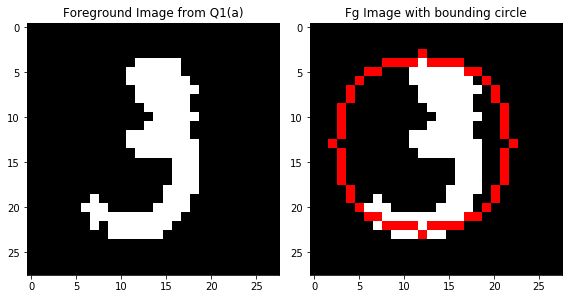

In [133]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(img, cmap = 'gray')
plt.title("Foreground Image from Q1(a)")
fig.add_subplot(rows, columns, 2)
plt.imshow(sample_y)
plt.title("Fg Image with bounding circle")
fig.tight_layout() 
plt.show()

### part (c)

In [459]:
X_train = np.array(pd.read_csv("dataset/mnist_train.csv"))[:,1:]
X_test = np.array(pd.read_csv("dataset/mnist_test.csv"))[:,1:]
y_label_train = np.array(pd.read_csv("dataset/mnist_train.csv"))[:,0] + 1
y_label_test = np.array(pd.read_csv("dataset/mnist_test.csv"))[:,0] + 1
y_train = np.array(pd.read_csv("dataset/Q1fg_mask_train.csv", header = None))
y_test = np.array(pd.read_csv("dataset/Q1fg_mask_test.csv", header = None))
y_train[y_train >=1 ] = 1
y_test[y_test >=1 ] = 1

### Segmentation Dataset
In this datasset each pixel has an label associated with it, which is to predicted by the model in Q4. <br>
**Dataset Size :** (n_samples, 56,56,1)<br>

number of classes = 11 <br>

**Classes :** <br>
* class 0 : background class
* class 1 : number 0 
* class 2 : number 1
* class 3 : number 2
* class 4 : number 3
* class 5 : number 4
* class 6 : number 5
* class 7 : number 6
* class 8 : number 7
* class 9 : number 8
* class 10 : number 9




In [460]:
# Creating the training Set
q4_dataset_x_train = []
q4_dataset_y_train = []

indexes = np.arange(60000)
while(len(indexes) > 0):
    e1 = random.choice(indexes)
    indexes = np.delete(indexes, np.where(indexes == e1)[0][0])
    e2 = random.choice(indexes)
    indexes = np.delete(indexes, np.where(indexes == e2)[0][0])
    e3 = random.choice(indexes)
    indexes = np.delete(indexes, np.where(indexes == e3)[0][0])
    e4 = random.choice(indexes)
    indexes = np.delete(indexes, np.where(indexes == e4)[0][0])
    

    img1, y1 = X_train[e1].reshape((28,28)), y_train[e1].reshape((28,28))*y_label_train[e1]
    img2, y2 = X_train[e2].reshape((28,28)), y_train[e2].reshape((28,28))*y_label_train[e2]
    img3, y3 = X_train[e3].reshape((28,28)), y_train[e3].reshape((28,28))*y_label_train[e3]
    img4, y4 = X_train[e4].reshape((28,28)), y_train[e4].reshape((28,28))*y_label_train[e4]
    
    final_img = np.zeros((56,56))
    final_seg = np.zeros((56,56))
    final_img[0:28,0:28] = img1
    final_img[0:28,28:] = img2
    final_img[28:,0:28] = img3
    final_img[28:,28:] = img4
    
    final_seg[0:28,0:28] = y1
    final_seg[0:28 ,28:] = y2
    final_seg[28:,0:28] = y3
    final_seg[28:,28:] = y4
    
    q4_dataset_x_train.append(final_img.flatten())
    q4_dataset_y_train.append(final_seg.flatten())
    
q4_dataset_x_train = np.array(q4_dataset_x_train)
q4_dataset_y_train = np.array(q4_dataset_y_train)



###### Saving the dataset in a .csv file.

In [ ]:
with open('dataset/question4/Q1image_segmentation_train_x.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerows(q4_dataset_x_train)
with open('dataset/question4/Q1image_segmentation_train_y.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerows(q4_dataset_y_train)

In [461]:
# Creating the Test Set
q4_dataset_x_test = []
q4_dataset_y_test = []

indexes = np.arange(10000)
while(len(indexes) > 0):
    e1 = random.choice(indexes)
    indexes = np.delete(indexes, np.where(indexes == e1)[0][0])
    e2 = random.choice(indexes)
    indexes = np.delete(indexes, np.where(indexes == e2)[0][0])
    e3 = random.choice(indexes)
    indexes = np.delete(indexes, np.where(indexes == e3)[0][0])
    e4 = random.choice(indexes)
    indexes = np.delete(indexes, np.where(indexes == e4)[0][0])
    

    img1, y1 = X_test[e1].reshape((28,28)), y_test[e1].reshape((28,28))*y_label_test[e1]
    img2, y2 = X_test[e2].reshape((28,28)), y_test[e2].reshape((28,28))*y_label_test[e2]
    img3, y3 = X_test[e3].reshape((28,28)), y_test[e3].reshape((28,28))*y_label_test[e3]
    img4, y4 = X_test[e4].reshape((28,28)), y_test[e4].reshape((28,28))*y_label_test[e4]
    
    final_img = np.zeros((56,56))
    final_seg = np.zeros((56,56))
    final_img[0:28,0:28] = img1
    final_img[0:28,28:] = img2
    final_img[28:,0:28] = img3
    final_img[28:,28:] = img4
    
    final_seg[0:28,0:28] = y1
    final_seg[0:28 ,28:] = y2
    final_seg[28:,0:28] = y3
    final_seg[28:,28:] = y4
    
    q4_dataset_x_test.append(final_img.flatten())
    q4_dataset_y_test.append(final_seg.flatten())
    
q4_dataset_x_test = np.array(q4_dataset_x_test)
q4_dataset_y_test = np.array(q4_dataset_y_test)


###### Saving the dataset in a .csv file.

In [ ]:
with open('dataset/question4/Q1image_segmentation_test_x.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerows(q4_dataset_x_test)
with open('dataset/question4/Q1image_segmentation_test_y.csv', 'a+', newline ='') as f:
    write = csv.writer(f)
    write.writerows(q4_dataset_y_test)

###### Sample Visualization

[ 0.  1.  3.  7. 10.]


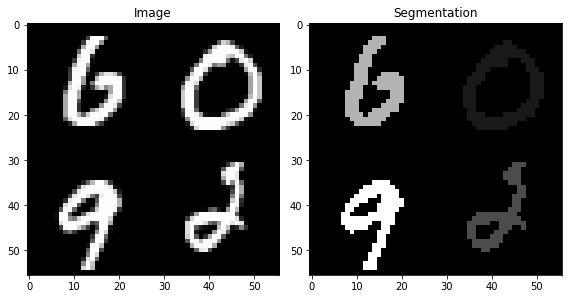

In [463]:
idx = 45
sample_x = q4_dataset_x_train[idx].reshape((56,56))
sample_y = q4_dataset_y_train[idx].reshape((56,56))

print(np.unique(sample_y))
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(sample_x, cmap = 'gray')
plt.title("Image")
fig.add_subplot(rows, columns, 2)
plt.imshow(sample_y, cmap = 'gray')
plt.title("Segmentation")
fig.tight_layout() 
plt.show()

## Question 2

Train a DL network from scratch for performing **foreground extraction** on the new dataset obtained in Q1 (a). Report your test performance using Jaccard similarity. [3 Marks]

In [114]:
X_train_df = pd.read_csv("dataset/mnist_train.csv")
X_test_df = pd.read_csv("dataset/mnist_test.csv")


y_train_df = pd.read_csv("dataset/Q1fg_mask_train.csv", header = None)
y_test_df = pd.read_csv("dataset/Q1fg_mask_test.csv", header= None)

In [115]:
X_train = np.array(X_train_df)[:,1:]
X_test = np.array(X_test_df)[:,1:]
y_train = np.array(y_train_df)
y_test = np.array(y_test_df)


X_train = X_train.reshape((X_train.shape[0], 28,28,1))
X_test = X_test.reshape((X_test.shape[0], 28,28,1))
y_train = y_train.reshape((y_train.shape[0], 28,28,1))
y_test = y_test.reshape((y_test.shape[0], 28,28,1))

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Defining the Model
**The Architecture of the model** 

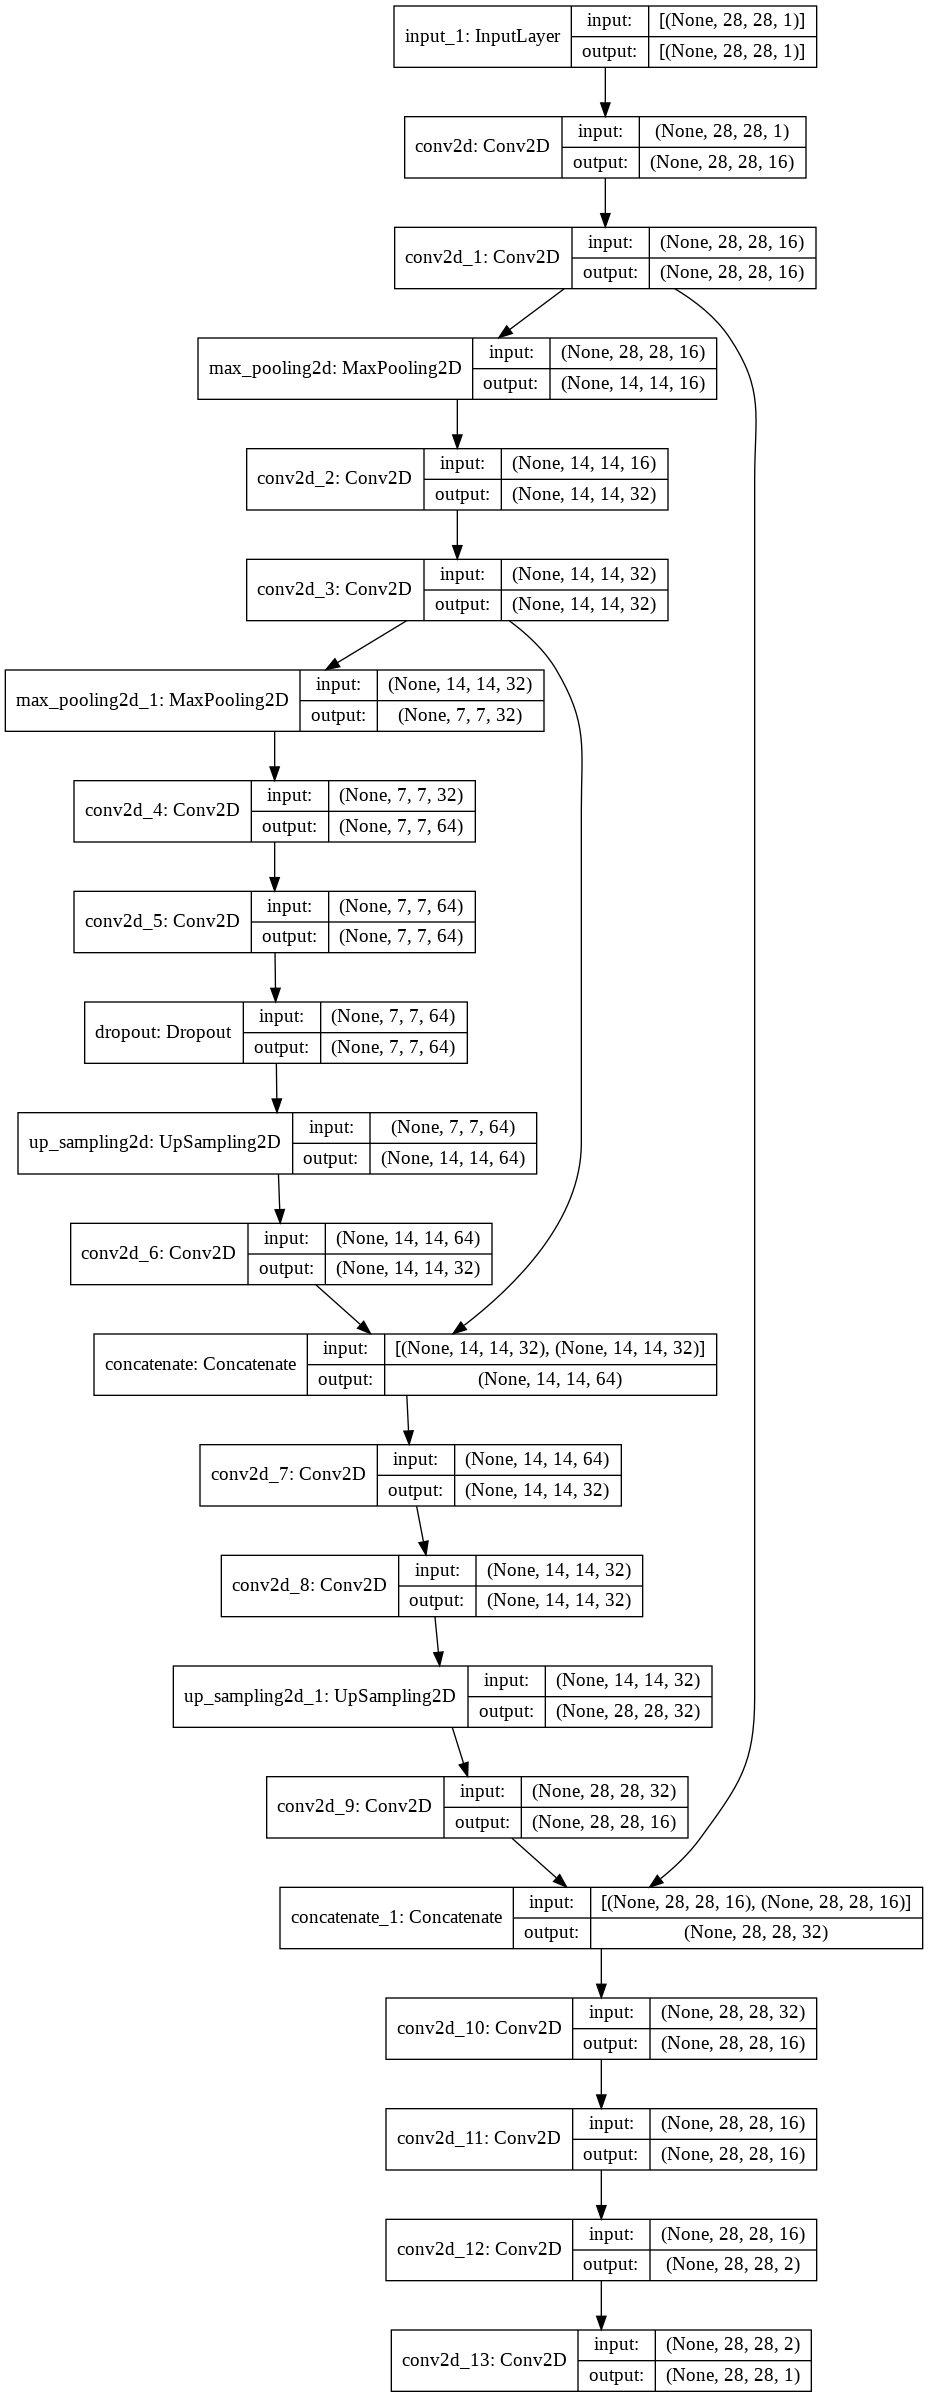

In [112]:
Image(filename='modelQ2.png') 


In [ ]:
def SkipNet(input_shape = (28,28,1) ):
    
    inputs = Input(input_shape)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.2)(conv3)

    up4 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop3))
    merge4 = concatenate([conv2,up4], axis = 3)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    up5 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv1,up5], axis = 3)
    conv5 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv6 = Conv2D(1, 1, activation = 'sigmoid')(conv5)

    model = Model(inputs = inputs, outputs = conv6, name = "SkipNet")

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    return model
    

###### Training from sratch

Parameters :  <br>
* Optimizer : Adam optimization algorithm
* loss : Binary Crossentropy
* Learning Rate : 0.0001
* epochs : 20
* batch size : 256
* metrics : accuracy

In [ ]:
model = SkipNet()
model.fit(X_train, y_train, epochs = 20, batch_size = 256) 

Model: "SkipNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 28, 28, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 28, 28, 16)   2320        conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 14, 14, 16)   0           conv2d_29[0][0]                  
____________________________________________________________________________________________

###### Saving the weights 



In [ ]:
model.save('ModelZoo/FgExtractor')

INFO:tensorflow:Assets written to: ModelZoo/FgExtractor/assets


###### Loading the weights


In [116]:
from tensorflow import keras
model = keras.models.load_model('ModelZoo/FgExtractor')

###### Evaluating on the test set


In [117]:
y_pred = model.predict(X_test)
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >= 0.5] = 1

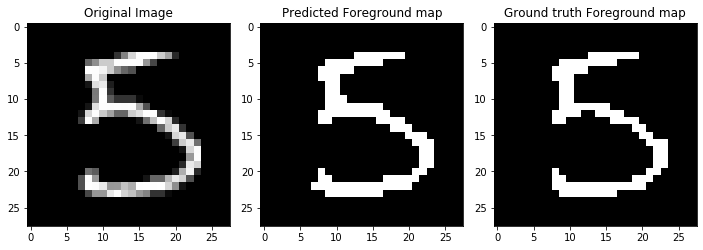

In [118]:
idx = 15
img = np.squeeze(X_test[idx])
pred = np.squeeze(y_pred[idx])
y = np.squeeze(y_test[idx])
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(img, cmap = 'gray')
plt.title("Original Image")
fig.add_subplot(rows, columns, 2)
plt.imshow(pred, cmap = "gray")
plt.title("Predicted Foreground map")
fig.add_subplot(rows, columns, 3)
plt.imshow(y, cmap = "gray")
plt.title("Ground truth Foreground map")
fig.tight_layout() 
plt.show()


##### Calculating the jaccard Similarity

In [122]:
avg_jacc_score = 0
for i in range(len(y_pred)):
    jc = jaccard_score(y_test[i].flatten(), y_pred[i].flatten(), average = 'binary')
    avg_jacc_score+=jc
avg_jacc_score/=len(y_pred)
print("Average \033[1m Jaccard Similarity \033[0m on the Test set :", avg_jacc_score)

Average  Jaccard Similarity  on the Test set : 0.9517986598096035




## Question 3

Train a DL network from scratch for performing classification with circlization on the new dataset obtained in Q1 (b). Report your test performance using Jaccard Similarity. [4 Marks] <br>
**Note:** If the classification is already wrong, the Jaccard Similarity score will become zero.

###### Reading the Dataset

In [4]:
X_train_df = pd.read_csv("dataset/mnist_train.csv")
X_test_df = pd.read_csv("dataset/mnist_test.csv")
Y_train_df =  pd.read_csv("dataset/Q1b_center_rad_train.csv")
Y_test_df = pd.read_csv("dataset/Q1b_center_rad_test.csv")

In [5]:
Y_train_df

,label,x,y,radius
0,5,0.46,0.50,0.66
1,0,0.46,0.46,0.51
2,4,0.46,0.46,0.56
3,1,0.50,0.50,0.51
4,9,0.54,0.57,0.45
...,...,...,...,...
59995,8,0.50,0.54,0.56
59996,3,0.43,0.46,0.56
59997,5,0.50,0.50,0.66
59998,6,0.46,0.39,0.56


In [6]:
train_names = np.arange(60000).astype(str)
train_labels = Y_train_df.label.values
train_coor = Y_train_df[['x', 'y', 'radius']].values

test_names = np.arange(10000).astype(str)
test_labels = Y_test_df.label.values
test_coor = Y_test_df[['x', 'y', 'radius']].values

In [7]:
X_train = np.array(X_train_df)[:,1:]
X_test = np.array(X_test_df)[:,1:]

###### Creating the tf records

In [8]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

@tf.function
def preprocess_train(image_name, label, coor):
    image = tf.io.read_file('dataset/mnist_images/train/'+image_name + ".png")
    image = tf.image.decode_png(image, channels=1)

    return image, {'label': label, 'coor': coor}

@tf.function
def preprocess_test(image_name, label, coor):
    image = tf.io.read_file('dataset/mnist_images/test/'+image_name + ".png")
    image = tf.image.decode_png(image, channels=1)

    return image, {'label': label, 'coor': coor}

trainloader = tf.data.Dataset.from_tensor_slices((train_names, train_labels, train_coor))
testloader = tf.data.Dataset.from_tensor_slices((test_names, test_labels, test_coor))

trainloader = (
    trainloader
    .map(preprocess_train, num_parallel_calls=AUTO)
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

###### To calculate the discrete points inside the circle given the radius and center

In [9]:
def points_in_circle_np(radius, x0=0, y0=0):
    """
    To get all the logical points in a circle.
    
    Arguments
    ----------
    radius : Radius of the circle, int.
    x0 : x-coordinate of the center, int.
    y0 : y-coordinate of the center, int.
    
    """
    x_ = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    y_ = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((x_[:,np.newaxis] - x0)**2 + (y_ - y0)**2 <= radius**2)
    list_ = []
    for x, y in zip(x_[x], y_[y]):
        list_.append((x,y))
    return list_

### Defining the Model
**The Architecture of the model** 

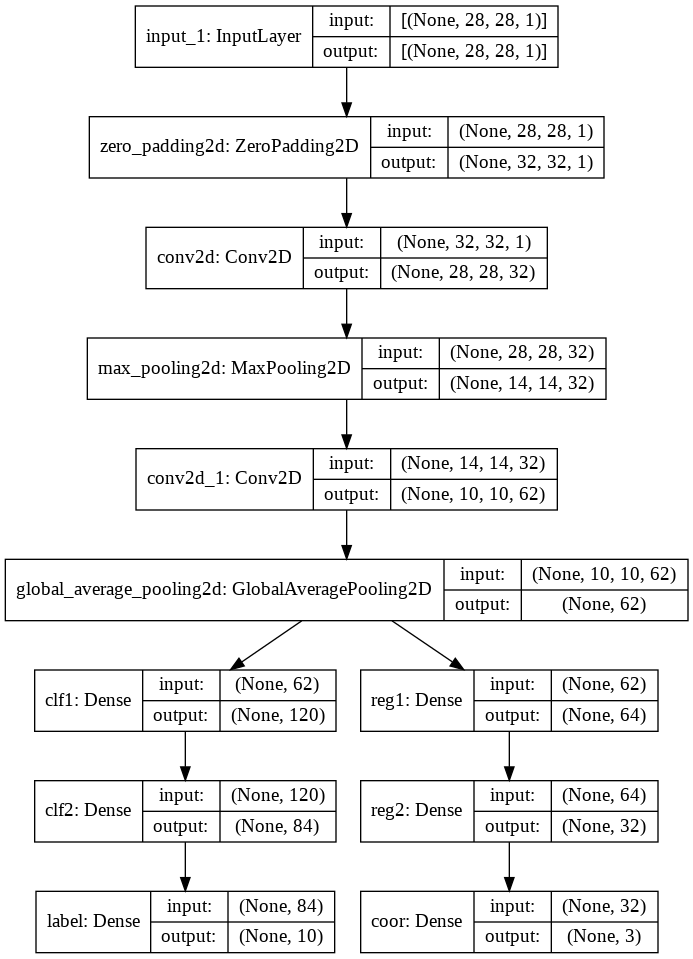

In [10]:
Image(filename='modelQ3.png') 

In [11]:
def SkipNet2(input_shape = (28,28,1), nclasses = 10):

    X_input = Input(input_shape)
    X = ZeroPadding2D((2,2))(X_input)
    X = Conv2D(32, (5,5), activation='relu')(X)
    X = MaxPooling2D((2,2))(X)
    X = Conv2D(62, (5,5), activation='relu')(X)
#     X = AveragePooling2D((2,2))(X)
    flat = GlobalAveragePooling2D()(X)

    
    clf = Dense(120, activation = 'relu', name  = 'clf1')(flat)
    
    clf = Dense(84, activation = 'relu', name = 'clf2')(clf)
    
    clf = Dense(10, activation = 'softmax', name = 'label')(clf)

    reg = Dense(64, activation='relu', name = 'reg1')(flat)
    reg = Dense(32, activation='relu', name = 'reg2')(reg)
    reg = Dense(3, activation='sigmoid', name='coor')(reg)

    model =  Model(inputs=X_input, outputs=[clf, reg], name = "MyObjectDetectionNet")

    return model


In [12]:
model = SkipNet2()
model.summary()

Model: "MyObjectDetectionNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 32, 32, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   832         zero_padding2d[0][0]             
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 32)   0           conv2d[0][0]                     
_______________________________________________________________________________

In [13]:
losses = {'label': 'sparse_categorical_crossentropy',
          'coor': 'mse'}

loss_weights = {'label': 1.0,
                'coor': 1.0}
model.compile('adam', loss=losses, loss_weights=loss_weights, metrics=['acc'])

###### Training from sratch

Parameters :  <br>
* Optimizer : Adam optimization algorithm
* loss : Sparse Categorical Crossentropy and MSE
* epochs : 30
* batch size : 32
* metrics : accuracy

In [77]:
model.fit(trainloader,epochs=20)

Epoch 1/20
1875/1875 [==============================] - 108s 58ms/step - loss: 0.2904 - label_loss: 0.2828 - coor_loss: 0.0075 - label_acc: 0.9113 - coor_acc: 0.53223s - loss: 0.2971 - label_loss: 0.2894 - coor_loss: 0.0077 - label_
Epoch 2/20
1875/1875 [==============================] - 97s 52ms/step - loss: 0.0731 - label_loss: 0.0703 - coor_loss: 0.0027 - label_acc: 0.9779 - coor_acc: 0.6741
Epoch 3/20
1875/1875 [==============================] - 82s 44ms/step - loss: 0.0561 - label_loss: 0.0535 - coor_loss: 0.0026 - label_acc: 0.9832 - coor_acc: 0.6978 7s - l
Epoch 4/20
1875/1875 [==============================] - 83s 44ms/step - loss: 0.0443 - label_loss: 0.0418 - coor_loss: 0.0025 - label_acc: 0.9870 - coor_acc: 0.7044 2s - loss: 0.0443 - label_loss: 0.0418 - coor_loss: 0.0025 - label_acc:
Epoch 5/20
1875/1875 [==============================] - 90s 48ms/step - loss: 0.0393 - label_loss: 0.0369 - coor_loss: 0.0024 - label_acc: 0.9881 - coor_acc: 0.7119 - ETA: 4s - loss: 0.0398 - l

###### Saving the weights 


In [78]:
model.save('ModelZoo/ObjectLocalizer')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ModelZoo/ObjectLocalizer\assets


###### Loading the weights 


In [14]:
from tensorflow import keras
model = keras.models.load_model('ModelZoo/ObjectLocalizer')

###### Evaluating on the test set


In [15]:
y_pred,y_coor = model.predict(testloader)

In [16]:
y_pred[y_pred < 0.5] = 0
y_pred[y_pred >=0.5] = 1
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [17]:
print(y_coor)
y_coor[:,0] = y_coor[:,0]*28
y_coor[:,1] = y_coor[:,1]*28
y_coor[:,2] = y_coor[:,2]*28/(2)**0.5


[[0.47272468 0.57472044 0.526576  ]
 [0.51313406 0.4295074  0.5609449 ]
 [0.49180645 0.44644102 0.46394607]
 ...
 [0.563763   0.5231803  0.49714106]
 [0.55173963 0.52794296 0.54207116]
 [0.45740402 0.3839616  0.44101104]]


In [51]:
idx = 448
img1 = X_test[idx].reshape(28,28)

In [52]:
img = cv2.imread('dataset/mnist_images/test/' + str(idx) + '.png')
x = y_coor[idx,0]
y = y_coor[idx,1]
center_coordinates = (x, y)  
color = (255, 0, 0)
thickness = 1
radius  = int(round(y_coor[idx,2]))
image = cv2.circle(img, center_coordinates, radius, color, thickness)

In [53]:
img = cv2.imread('dataset/mnist_images/test/' + str(idx) + '.png')
x = int(round(test_coor[idx,0]*28,2))
y = int(round(test_coor[idx,1]*28,2))
center_coordinates = (x, y)  
color = (255, 0, 0)
thickness = 1
radius  = int(round(test_coor[idx,2]*28/(2)**0.5))
image_gt = cv2.circle(img, center_coordinates, radius, color, thickness)

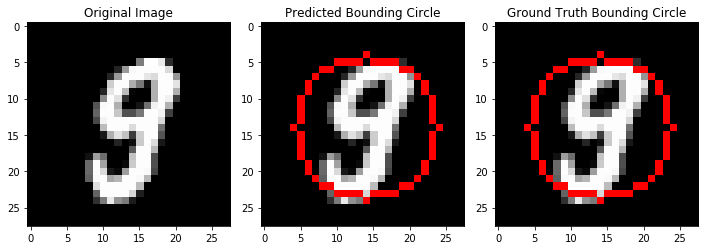

In [54]:
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(img1, cmap = 'gray')
plt.title("Original Image")
fig.add_subplot(rows, columns, 2)
plt.imshow(image, cmap = "gray")
plt.title("Predicted Bounding Circle")
fig.add_subplot(rows, columns, 3)
plt.imshow(image_gt, cmap = "gray")
plt.title("Ground Truth Bounding Circle")
fig.tight_layout() 
plt.show()

### Jaccard Similarity
Jaccard Similarity computes the intersection of two binary marks BM1 and BM2 divided by the union of BW1 and BW2. <br>
<br>
$$ J(A,B) = \frac{|A \cap B|}{|A \cup B|} $$
where A,B are the two binary masks.

In [61]:
def jaccard_similarity(binary_mask1, binary_mask2):
    """
    Returns the jaccard similarity score for 2 binary masks. 
    
    Arguments
    ---------
    binary_mask1 : list of all the points in mask A. 
    binary_mask2 : list of all the points in mask B.
    
    Returns 
    -------
    IOU : Jaccard Similarity of the two masks.
    """
    
    intersection = len(list(set(binary_mask1).intersection(set(binary_mask2))))
    union = len(set(binary_mask1).union(set(binary_mask2)))
    if(union == 0):
        return 0
    return float(intersection) / union

###### Calculating the average jaccard score

We would be calculating the jaccard score into two parts  : 
1. Calculating the jaccard scores on the input image and the predicted circle. 
2. Calculating the jaccard scores on the Ground truth circle and the predicted circle. 

**1. Calculating the jaccard scores on the input image and the predicted circle.** 

In [64]:
j_score=  0

for i in tqdm(range(len(X_test)),position = 0, desc = "Progress : "):
    img = X_test[i].reshape(28,28)
    idxs = np.where(img > 0)
    x = idxs[0]
    y = idxs[1]
    pixels = [(i,j) for (i,j) in zip(x,y)]
    c_x = round(y_coor[i,0])
    c_y = round(y_coor[i,1])
    rad = int(round(y_coor[i,2]))
    y_p = y_pred[i]
    y_t = test_labels[i]
    if(y_p == y_t):
        points_circle = points_in_circle_np(rad,c_x,c_y)
        score = jaccard_similarity(points_circle,pixels)
        j_score+=score
    else:
        j_score+=0

avg_jacc_score = j_score/(len(X_test))
print("The \033[1m average jaccard score on input image and predicted circle \033[0m is : ", avg_jacc_score)

Progress : 100%|████████████████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.69it/s]

The  average jaccard score on input image and predicted circle  is :  0.39441413368874534


**2. Calculating the jaccard scores on the Ground truth cicles and the predicted circle.** 

In [63]:
j_score=  0

for i in tqdm(range(len(X_test)),position = 0, desc = "Progress : "):
    x,y,r = test_coor[i]
    x = round(x*28)
    y = round(y*28)
    r = int(round(r*28/(2)**0.5))
    
    c_x = round(y_coor[i,0])
    c_y = round(y_coor[i,1])
    rad = int(round(y_coor[i,2]))
    y_p = y_pred[i]
    y_t = test_labels[i]
    if(y_p == y_t):
        points_circle = points_in_circle_np(rad,c_x,c_y)
        gt_circle = points_in_circle_np(r,x,y)
        score = jaccard_similarity(gt_circle,points_circle)
        j_score+=score
    else:
        j_score+=0

avg_jacc_score = j_score/(len(X_test))
print("The \033[1m average jaccard score on Ground truth Circle and predicted circle \033[0m is : ", avg_jacc_score)

Progress : 100%|███████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1179.43it/s]

The  average jaccard score on Ground truth Circle and predicted circle  is :  0.8457513813013228


### Question 4
Train a DL network from scratch for performing semantic segmentation on the new dataset obtained in Q1 (c). Report your test performance using Jaccard Similarity. [4 Marks]


In [135]:
X_train_df = pd.read_csv("dataset/question4/Q1image_segmentation_train_x.csv", header = None)
y_train_df = pd.read_csv("dataset/question4/Q1image_segmentation_train_y.csv", header= None)
X_test_df = pd.read_csv("dataset/question4/Q1image_segmentation_test_x.csv", header = None)
y_test_df = pd.read_csv("dataset/question4/Q1image_segmentation_test_y.csv", header= None)

In [136]:
X_train = np.array(X_train_df).astype(int)
y_train_orig = np.array(y_train_df).astype(int)
X_test = np.array(X_test_df).astype(int)
y_test_orig = np.array(y_test_df).astype(int)

In [137]:
X_train = X_train.reshape((X_train.shape[0], 56,56,1))
y_train_orig = y_train_orig.reshape((y_train_orig.shape[0], 56,56,1))
X_test = X_test.reshape((X_test.shape[0], 56,56,1))
y_test_orig = y_test_orig.reshape((y_test_orig.shape[0], 56,56,1))

In [ ]:
#To load the train set (takes a lot of RAM)

y_train = np.zeros((y_train_orig.shape[0], 56,56,11), dtype = int)

for i in tqdm(range(y_train.shape[0]), position = 0, desc = "Progress :"):
    for j in range(y_train.shape[1]):
        for k in range(y_train.shape[2]):
            y_train[i,j,k,y_train_orig[i,j,k,0]] = 1
    

print(X_train.shape)
print(y_train.shape)

Progress :: 100%|██████████| 2500/2500 [00:05<00:00, 473.46it/s]


In [138]:
#To load the test set (takes a lot of RAM)

y_test = np.zeros((y_test_orig.shape[0], 56,56,11), dtype = int)

for i in tqdm(range(y_test.shape[0]), position = 0, desc = "Progress :"):
    for j in range(y_test.shape[1]):
        for k in range(y_test.shape[2]):
            y_test[i,j,k,y_test_orig[i,j,k,0]] = 1
print(X_test.shape)
print(y_test.shape)

Progress :: 100%|█████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 281.93it/s]

(2500, 56, 56, 1)
(2500, 56, 56, 11)


### Defining the Model
**The Architecture of the model** 

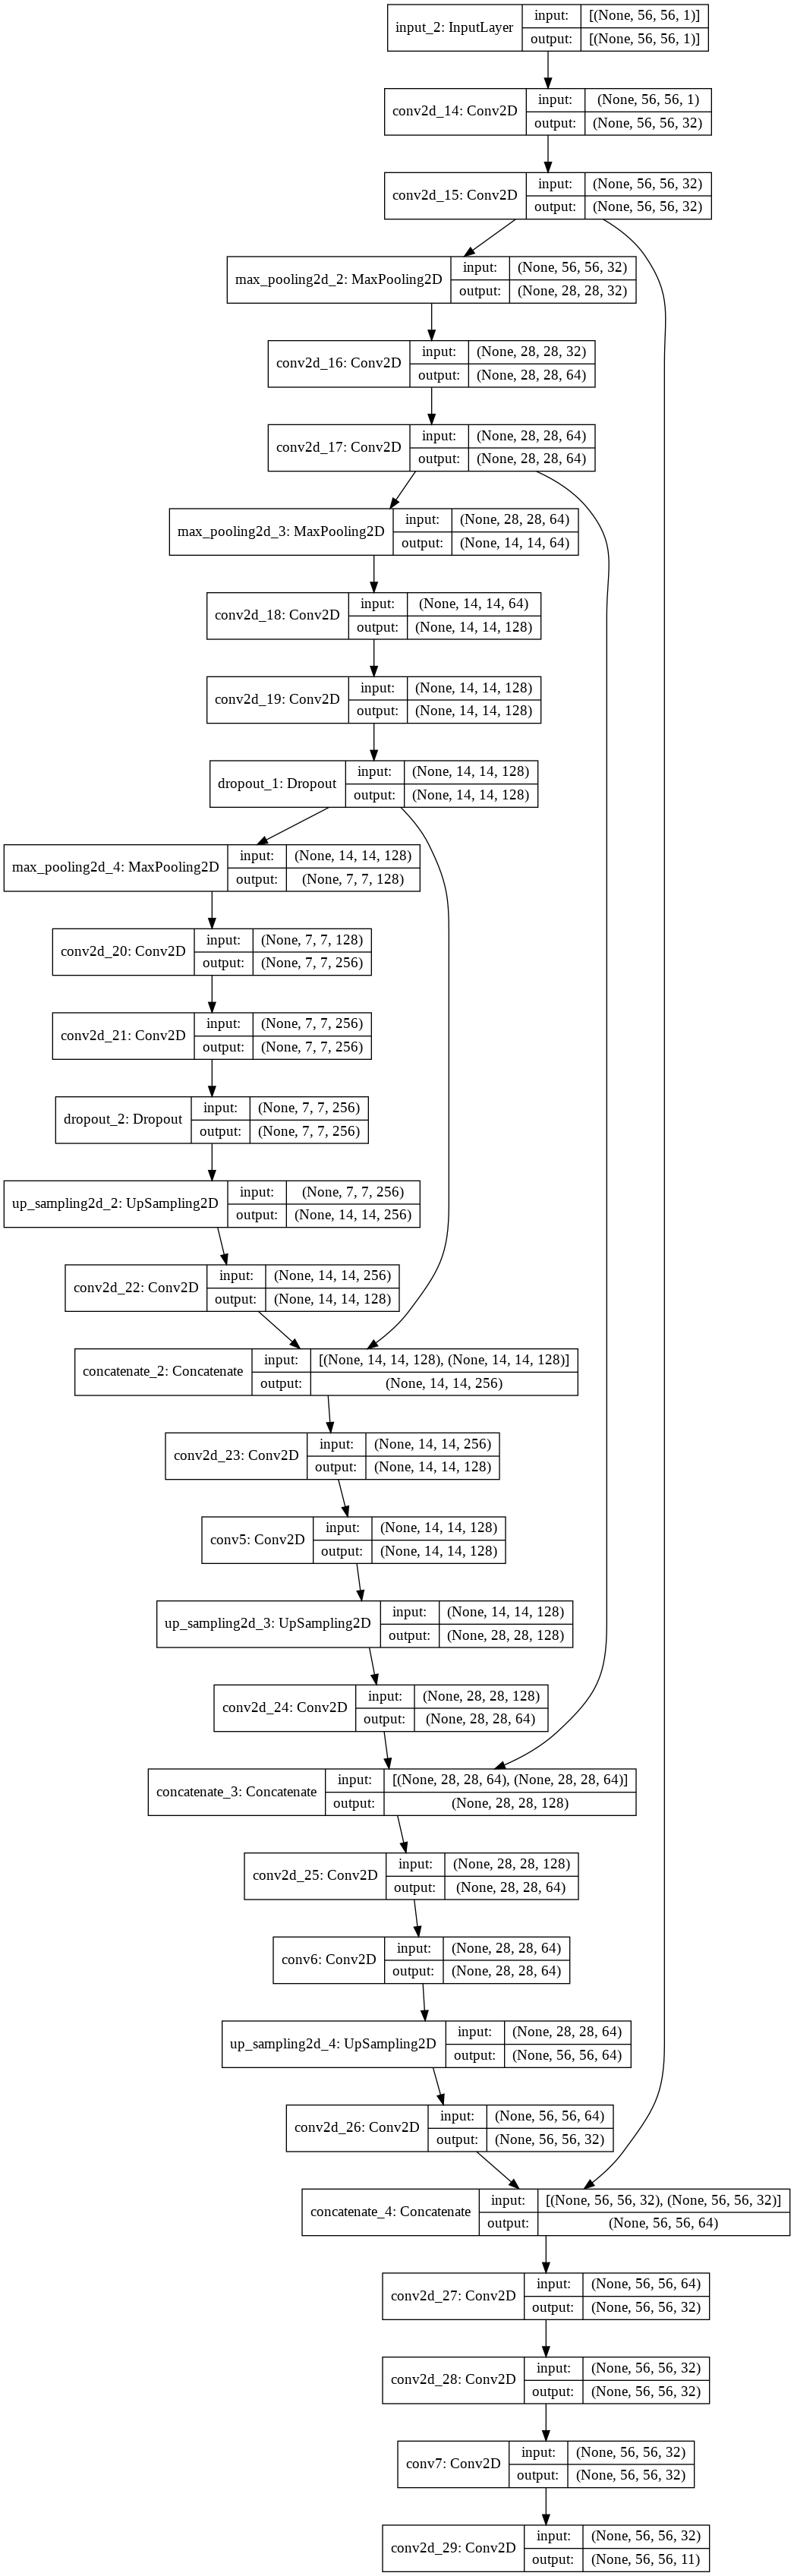

In [124]:
Image(filename='modelQ4.png') 

In [ ]:
def SkipNet3(input_shape = (56,56,1) ):
    
    inputs = Input(input_shape)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    drop3 = Dropout(0.2)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.2)(conv4)


    up5 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop4))
    merge5 = concatenate([drop3,up5], axis = 3)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge5)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name = 'conv5')(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name = 'conv6')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name = 'conv7')(conv7)
    conv8 = Conv2D(11, 1, activation = 'softmax')(conv7)

    model = Model(inputs = inputs, outputs = conv8, name = "SkipNet3")

    model.compile(optimizer = Adam(lr = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    return model

In [ ]:
model = SkipNet3()

Model: "SkipNet3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 56, 56, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 56, 56, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 56, 56, 32)   9248        conv2d_16[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 28, 28, 32)   0           conv2d_17[0][0]                  
___________________________________________________________________________________________

###### Training from sratch

Parameters :  <br>
* Optimizer : Adam optimization algorithm
* loss : Categorical Crossentropy
* Learning Rate : 0.001
* epochs : 50
* batch size : 512
* metrics : accuracy

In [ ]:
model.fit(X_train, y_train, epochs = 50, batch_size = 512) 

Epoch 1/50
30/30 [==============================] - 33s 1s/step - loss: 1.0161 - accuracy: 0.8415
Epoch 2/50
30/30 [==============================] - 33s 1s/step - loss: 0.4271 - accuracy: 0.8591
Epoch 3/50
30/30 [==============================] - 33s 1s/step - loss: 0.4016 - accuracy: 0.8612
Epoch 4/50
30/30 [==============================] - 33s 1s/step - loss: 0.3919 - accuracy: 0.8619
Epoch 5/50
30/30 [==============================] - 33s 1s/step - loss: 0.3854 - accuracy: 0.8625
Epoch 6/50
30/30 [==============================] - 33s 1s/step - loss: 0.3797 - accuracy: 0.8639
Epoch 7/50
30/30 [==============================] - 33s 1s/step - loss: 0.3745 - accuracy: 0.8696
Epoch 8/50
30/30 [==============================] - 33s 1s/step - loss: 0.3702 - accuracy: 0.8707
Epoch 9/50
30/30 [==============================] - 33s 1s/step - loss: 0.3666 - accuracy: 0.8713
Epoch 10/50
30/30 [==============================] - 33s 1s/step - loss: 0.3632 - accuracy: 0.8719
Epoch 11/50
30/30 [

###### Saving the weights


In [ ]:
model.save('ModelZoo/semanticSegmentor')

INFO:tensorflow:Assets written to: ModelZoo/semanticSegmentor/assets


###### Loading the weights


In [139]:
from tensorflow import keras
model = keras.models.load_model('ModelZoo/semanticSegmentor')

###### Evaluating on the test set


In [140]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 3)
y_pred = y_pred.reshape((y_pred.shape[0], 56,56,1))

In [156]:
idx = 98
img = np.squeeze(X_test[idx])
sample_y = np.squeeze(y_pred[idx])

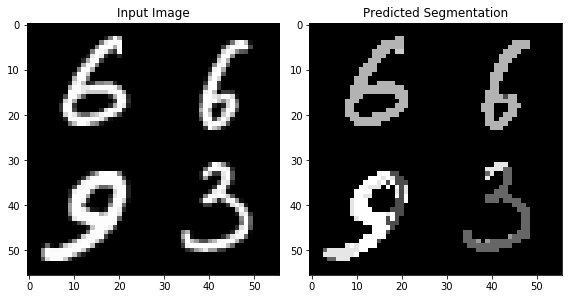

In [157]:
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(img, cmap = 'gray')
plt.title("Input Image")
fig.add_subplot(rows, columns, 2)
plt.imshow(sample_y, cmap = "gray")
plt.title("Predicted Segmentation")
fig.tight_layout() 
plt.show()

###### Calcuating the Average Jaccard Similarity

In [159]:
avg_jacc_score = 0
for i in range(len(y_pred)):
    jc = jaccard_score(y_test_orig[i].flatten(), y_pred[i].flatten(), average = 'micro')
    avg_jacc_score+=jc
avg_jacc_score/=len(y_pred)
print("\033[1mAverage Jaccard Similarity\033[0m on the Test set :", avg_jacc_score)

Average Jaccard Similarity on the Test set : 0.9685201373796278


$$----------------- END -----------------$$